<a href="https://colab.research.google.com/github/AdarshanandIITBHU/Batch_Reactor_project/blob/main/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
def reversible_batch_reactor(concentrations, t, k1, k_minus_1, k2, k_minus_2):

    A, B, C = concentrations

    dAdt = -k1 * A + k_minus_1 * B
    dBdt = (k1 * A - k_minus_1 * B) - (k2 * B - k_minus_2 * C)
    dCdt = k2 * B - k_minus_2 * C

    return [dAdt, dBdt, dCdt]

In [23]:
temperatures = np.linspace(290, 350, 10)     # 10 points from 290K to 350K
C0_list = np.linspace(0.5, 2.5, 10)
catalyst_levels = np.linspace(0.5, 1.5, 5)

pH_levels = [6.0, 7.0, 8.0]

pressures = [1, 5, 10]

mixing_rpms = [100, 300, 500]

k_base = 0.01

time_for_simulation = np.linspace(0, 100, 1000)
time_for_csv = np.linspace(0,100,20)

In [27]:
from tqdm import tqdm
print("Starting simulation for LARGE dataset with improved efficiency...")

list_of_dataframes = []

total_sims = len(temperatures) * len(C0_list) * len(catalyst_levels) * len(pH_levels) * len(pressures) * len(mixing_rpms)

for T in tqdm(temperatures, desc="Overall Progress"):
    for C0 in C0_list:
        for cat in catalyst_levels:
            for pH in pH_levels:
                for P in pressures:
                    for rpm in mixing_rpms:
                        pH_effect = np.exp(-0.1 * (pH - 7)**2)
                        pressure_effect = (1 + 0.005 * (P - 1))
                        rpm_effect = (1 - np.exp(-0.005 * rpm))
                        k1_base = k_base * cat * np.exp(0.05 * (T - 300))
                        k2_base = k1_base * 0.8
                        k1 = k1_base * pH_effect * pressure_effect * rpm_effect
                        k2 = k2_base * pH_effect * pressure_effect * rpm_effect
                        k_minus_1 = k1 * 0.2
                        k_minus_2 = k2 * 0.1

                        initial_concentrations = [C0, 0, 0]
                        concentration_over_time = odeint(
                            reversible_batch_reactor,
                            initial_concentrations,
                            time_for_simulation,
                            args=(k1, k_minus_1, k2, k_minus_2)
                        )

                        run_df = pd.DataFrame({
                            'Time': time_for_simulation,
                            'A': concentration_over_time[:, 0],
                            'B': concentration_over_time[:, 1],
                            'C': concentration_over_time[:, 2]
                        })
                        run_df['Temperature'], run_df['C0'], run_df['Catalyst'] = T, C0, cat
                        run_df['pH'], run_df['Pressure'], run_df['RPM'] = pH, P, rpm

                        run_df_downsampled = run_df[run_df['Time'].isin(time_for_csv)].copy()

                        list_of_dataframes.append(run_df_downsampled)

print("\nAll simulations complete. Consolidating data...")
final_df = pd.concat(list_of_dataframes, ignore_index=True)

print(f"Simulation finished! Generated {len(final_df)} data points.")

Starting simulation for LARGE dataset with improved efficiency...


Overall Progress: 100%|██████████| 10/10 [00:33<00:00,  3.30s/it]



All simulations complete. Consolidating data...
Simulation finished! Generated 27000 data points.


In [28]:
output_filename = 'reactor_dataset.csv'
final_df.to_csv(output_filename, index=False)

print(f"dataset successfully saved as '{output_filename}'")
final_df.info()
final_df.head() #

dataset successfully saved as 'reactor_dataset.csv'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27000 entries, 0 to 26999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         27000 non-null  float64
 1   A            27000 non-null  float64
 2   B            27000 non-null  float64
 3   C            27000 non-null  float64
 4   Temperature  27000 non-null  float64
 5   C0           27000 non-null  float64
 6   Catalyst     27000 non-null  float64
 7   pH           27000 non-null  float64
 8   Pressure     27000 non-null  int64  
 9   RPM          27000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 2.1 MB


,Time,A,B,C,Temperature,C0,Catalyst,pH,Pressure,RPM
0,0.0,0.500000,0.000000,0.000000,290.0,0.5,0.5,6.0,1,100
1,100.0,0.449350,0.048485,0.002164,290.0,0.5,0.5,6.0,1,100
2,0.0,0.500000,0.000000,0.000000,290.0,0.5,0.5,6.0,1,300
3,100.0,0.405844,0.086300,0.007856,290.0,0.5,0.5,6.0,1,300
4,0.0,0.500000,0.000000,0.000000,290.0,0.5,0.5,6.0,1,500


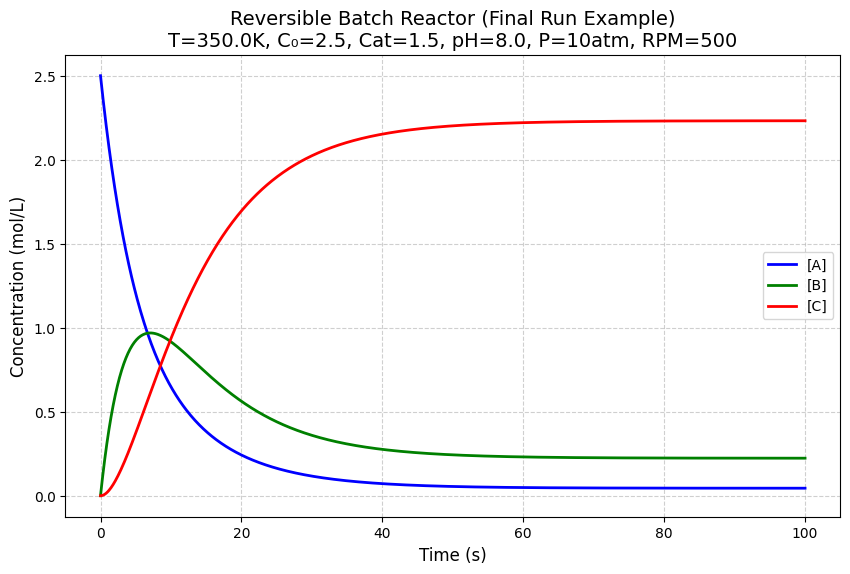

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(time_for_simulation, concentration_over_time[:, 0], label='[A]', color='blue', linewidth=2)
plt.plot(time_for_simulation, concentration_over_time[:, 1], label='[B]', color='green', linewidth=2)
plt.plot(time_for_simulation, concentration_over_time[:, 2], label='[C]', color='red', linewidth=2)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Concentration (mol/L)', fontsize=12)

plt.title(f'Reversible Batch Reactor (Final Run Example)\n'
          f'T={T:.1f}K, C₀={C0:.1f}, Cat={cat:.1f}, pH={pH}, P={P}atm, RPM={rpm}', fontsize=14)

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()